# View CPT Results for experiment "all_years-adj-cabinets_selected-parties"

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (10, 7)

## Topic word perplexity

In [2]:
import os

def load_perplexity_results(results_dir):
    perplexity_topic = pd.read_csv(os.path.join(results_dir, 'perplexity_topic.csv'), index_col=0)
    perplexity_opinion = pd.read_csv(os.path.join(results_dir, 'perplexity_opinion.csv'), index_col=0)
    
    return perplexity_topic, perplexity_opinion

In [3]:
results_dir = '/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties'

## Results for topics and opinions

In [4]:
# choose optimal number of topics based on perplexity results
nTopics = 100

In [5]:
# load results
import glob
import os
import re

def load_experiment_results(nTopics, results_dir):

    # document topic matrix (theta)
    theta = pd.read_csv(os.path.join(results_dir, 'theta_{}.csv'.format(nTopics)), index_col=0)

    # phi topic (transposed)
    phi_topic_t = pd.read_csv(os.path.join(results_dir, 'topics_{}.csv'.format(nTopics)), index_col=0, encoding='utf-8')

    # phi opinion (transposed) per perspective
    opinion_files = glob.glob('{}/opinions_*_{}.csv'.format(results_dir, nTopics))
    phis_opinion_t = {}
    for f in opinion_files:
        m = re.match(r'.+opinions_(.+).csv', f)
        name = m.group(1).replace('_{}'.format(nTopics), '')
        phis_opinion_t[name] = pd.read_csv(f, index_col=0, encoding='utf-8')
    return theta, phi_topic_t, phis_opinion_t

In [6]:
theta, phi_topic_t, phis_opinion_t = load_experiment_results(nTopics, results_dir)

### 'Weight' of the most important topic per document

Each topic has a certain weight in the document. We would like to see one (or a few) topics with high weight per document. Below are some basic statistics on the most important topic (highest weight) per document. 

In [7]:
def print_topic_weights(theta):
    a = theta.copy().apply(max, axis=1)
    a.sort(ascending=False)

    print 'Mean weight of most important topic: {} (std: {})'.format(a.mean(), a.std())
    print 'Min and max of most important topic: min: {}, max: {}'.format(a.min(), a.max())
    print 'Median weight of most important topic: ', a.median()

print_topic_weights(theta)

Mean weight of most important topic: 0.163671639893 (std: 0.106484725034)
Min and max of most important topic: min: 0.01, max: 0.667777777778
Median weight of most important topic:  0.143413729128


Line graph of the sorted topic weigths:

### Number of topics per document

The number of topics per document is calculated by counting the number of topic with weight above a certain threshold. The numer of topics per document should (roughly) be equivalent to the number of ``pm:topic``s per document (however, at the moment we do not have statistics of this).

0     5684
1    10289
2    11573
3     8805
4     4581
5     1450
6      322
7       34
8        5
dtype: int64


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


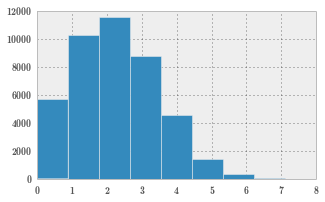

In [8]:
def display_number_of_topics_per_document(theta, threshold=0.05):
    topic_counts = theta.apply(lambda row: np.sum(row > threshold), axis=1)
    print topic_counts.value_counts(sort=False)
    topic_counts.hist(bins=len(topic_counts.value_counts()), figsize=(5,3));

display_number_of_topics_per_document(theta)

### Topics

In [9]:
from cptm.utils.controversialissues import jsd_opinions, filter_opinions, jsd_for_all_topics, average_pairwise_jsd

ps = [p for p in phis_opinion_t.keys() if p.startswith('Rutte I-')]
# ['Rutte I-GroenLinks', 'Rutte I-ChristenUnie', 'Rutte I-PVV', 'Rutte I-SGP', 
# 'Rutte I-VVD', 'Rutte I-PvdA', 'Rutte I-PvdD', 'Rutte I-SP', 'Rutte I-CDA', 'Rutte I-D66']
print ps

opinions = filter_opinions(ps, phis_opinion_t)
jsd = jsd_for_all_topics(opinions)
print 'max:', np.max(jsd), 'min:', np.min(jsd), 'avg:', np.mean(jsd)

['Rutte I-GroenLinks', 'Rutte I-ChristenUnie', 'Rutte I-PVV', 'Rutte I-SGP', 'Rutte I-VVD', 'Rutte I-PvdA', 'Rutte I-PvdD', 'Rutte I-SP', 'Rutte I-CDA', 'Rutte I-D66']
max: 0.842500105427 min: 0.361516402496 avg: 0.681275468002


In [10]:
from cptm.utils.topics import topic_str

def show_topic(t, top=10):
    """Return dataframe containing <top> topic words, weights of topic words and per perspective opinion words and
    weigths of opinion words.
    
    Parameters
        t : str - index of topic number
        top : int - the number of words to store in the dataframe
    
    Returns Pandas DataFrame
    """
    topic = phi_topic_t[t].copy()
    topic.sort(ascending=False)
    topic = topic[0:top]
    df_t = pd.DataFrame(topic)
    df_t.reset_index(level=0, inplace=True)
    df_t.columns = ['topic_{}'.format(t), 'weights_topic_{}'.format(t)]

    dfs = [df_t]

    for p, o in phis_opinion_t.iteritems():
        opinion = o[t].copy()
        opinion.sort(ascending=False)
        opinion = opinion[0:top]
        df_o = pd.DataFrame(opinion)
        df_o.reset_index(level=0, inplace=True)
        df_o.columns = ['opinion_{}_{}'.format(t, p), 'weights_opinion_{}_{}'.format(t, p)]
        dfs.append(df_o)
        
    return pd.concat(dfs, axis=1)

def print_topics(phi_topic_t, phis_opinion_t, nTopics, order=None):
    if order is None:
        print 'Ordering topics by topic number'
        print
        loop = range(nTopics)
    else:
        name = order.columns[0]
        print 'Ordering topics by {}'.format(name)
        print
        r = order.sort([name], ascending=False)
        print 'Min {}: {}, max jsd: {}'.format(name, np.min(order[name]), np.max(order[name]))
        print 'Average {}: {} (std: {}), median jsd: {}'.format(name, np.mean(order[name]), np.std(order[name]), np.median(order[name]))
        print
        loop = r.index

    for i in loop:
        if not order is None:
            print 'topic {}'.format(i)
            print ' vs. '.join([p for p in phis_opinion_t.keys()])
            print '{}: {}'.format(name, order.at[i, name])
            print
        pLabelsO = ['opinion_{}_{}'.format(i, p) for p, o in phis_opinion_t.iteritems()]
        pLabelsW = ['weights_opinion_{}_{}'.format(i, p) for p, o in phis_opinion_t.iteritems()]
        pLabels = []
        for l1, l2 in zip(pLabelsO, pLabelsW):
            pLabels.append(l1)
            pLabels.append(l2)
        print show_topic(str(i))[['topic_{}'.format(i), 'weights_topic_{}'.format(i)] + pLabels].to_latex(index=False, index_names=False, header=False)
        print

In [11]:
pw_jsd_data = np.load('/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties/perspective_jsd_100.npy')

In [12]:
from cptm.utils.controversialissues import jsd_opinions, filter_opinions, jsd_for_all_topics, average_pairwise_jsd
pd.set_option('precision', 5)
ps = ['Rutte I-VVD', 'Rutte I-SP']
jsd = average_pairwise_jsd(pw_jsd_data, phis_opinion_t, ps)
print 'max:', np.max(jsd), 'min:', np.min(jsd), 'avg:', np.mean(jsd)
jsd = pd.DataFrame(jsd, columns=['average pairwise jsd'])
opinions = filter_opinions(ps, phis_opinion_t)
print_topics(opinions, opinions, nTopics, order=jsd)

max: 0.39942362121 min: 0.103193458543 avg: 0.285738104248
Ordering topics by average pairwise jsd

Min average pairwise jsd: 0.103193458543, max jsd: 0.39942362121
Average average pairwise jsd: 0.285738104248 (std: 0.0525822140493), median jsd: 0.288499333882

topic 33
Rutte I-VVD vs. Rutte I-SP
average pairwise jsd: 0.39942362121

\begin{tabular}{lrlrlr}
\toprule
         asielzoeker &  0.0538 &    zorgvuldig &  0.0655 &       illegaal &  0.0558 \\
\midrule
         vreemdeling &  0.0342 &      illegaal &  0.0561 &      strafbaar &  0.0513 \\
              opvang &  0.0263 &        streng &  0.0306 &        medisch &  0.0418 \\
           terugkeer &  0.0239 &     strafbaar &  0.0213 &         veilig &  0.0227 \\
           procedure &  0.0238 &       kansarm &  0.0193 &      effectief &  0.0220 \\
 verblijfsvergunning &  0.0218 &  rechtvaardig &  0.0188 &           waar &  0.0212 \\
              pardon &  0.0203 &        veilig &  0.0184 &  discretionair &  0.0202 \\
            he

In [13]:
data = pd.read_csv('/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties/co_words_100.csv', index_col=0, encoding='utf-8')

In [14]:
data.loc['deeltijdwerker', :]

jsd    0.3657
Name: deeltijdwerker, dtype: float64

\begin{tabular}{lr}
\toprule
leerling                 &  0.9492 \\
\midrule
leraar                   &  0.9483 \\
kerndoel                 &  0.9433 \\
onderwijstijd            &  0.9430 \\
leerkracht               &  0.9420 \\
lerarenopleiding         &  0.9416 \\
basisvorming             &  0.9416 \\
bekwaamheidseis          &  0.9410 \\
onderbouw                &  0.9404 \\
commissie-dijsselbloem   &  0.9399 \\
zorgleerling             &  0.9397 \\
bovenbouw                &  0.9396 \\
schoolleider             &  0.9381 \\
onderwijsvernieuwing     &  0.9380 \\
urennorm                 &  0.9379 \\
onderwijsraad            &  0.9351 \\
vmbo                     &  0.9347 \\
kwalificatiedossier      &  0.9308 \\
lesuur                   &  0.9295 \\
schoolbegeleidingsdienst &  0.9274 \\
klassenverkleining       &  0.9264 \\
didactiek                &  0.9243 \\
leerweg                  &  0.9220 \\
vo-raad                  &  0.9206 \\
studiehuis               &  0.9188 \\
zij-instrome

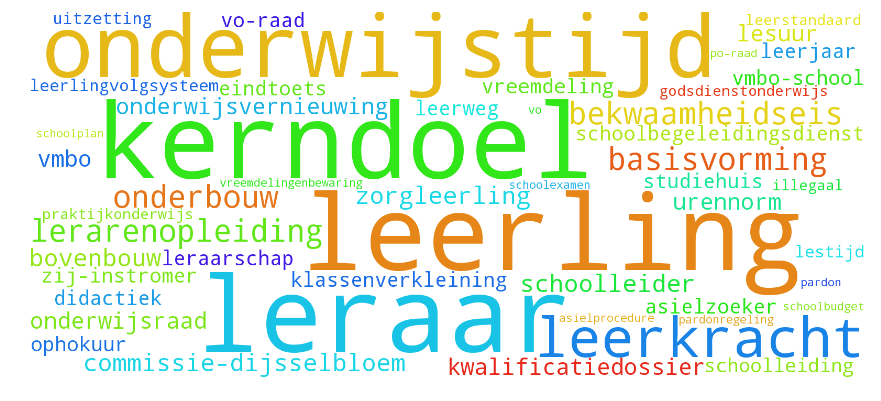

In [15]:
from wordcloud import WordCloud

top = pd.Series(data['jsd'])
top.sort(ascending=False)
print pd.DataFrame(top[:50]).to_latex(index=True, index_names=False, header=False)
#print top[:75]

words = [(wo, we) for wo, we in top[:50].iteritems()]
print words

wc = WordCloud(relative_scaling=0.7, prefer_horizontal=1.0, background_color="white", 
               height=700, width=1600,
               min_font_size=10, max_font_size=200).fit_words(words)
# font_path=font
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [16]:
data = pd.read_csv('/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties/co_words_Rutte_I_100.csv', index_col=0, encoding='utf-8')

\begin{tabular}{lr}
\toprule
student                   &  0.8418 \\
\midrule
collegegeld               &  0.8379 \\
master                    &  0.8331 \\
masteropleiding           &  0.8316 \\
mln                       &  0.8303 \\
sollicitatieplicht        &  0.8268 \\
noodfonds                 &  0.8262 \\
langdurigheidstoeslag     &  0.8256 \\
basisbeurs                &  0.8252 \\
agent                     &  0.8248 \\
eurozone                  &  0.8248 \\
bijstandsuitkering        &  0.8245 \\
collegegelddifferentiatie &  0.8237 \\
langstudeerder            &  0.8236 \\
hogeschool                &  0.8236 \\
werkvoorziening           &  0.8210 \\
deeltijdstudent           &  0.8209 \\
wo                        &  0.8208 \\
korpsbeheerder            &  0.8206 \\
accreditatieorgaan        &  0.8204 \\
accreditatie              &  0.8201 \\
hbo-instelling            &  0.8201 \\
politieman                &  0.8179 \\
korpschef                 &  0.8174 \\
bijstandswet              

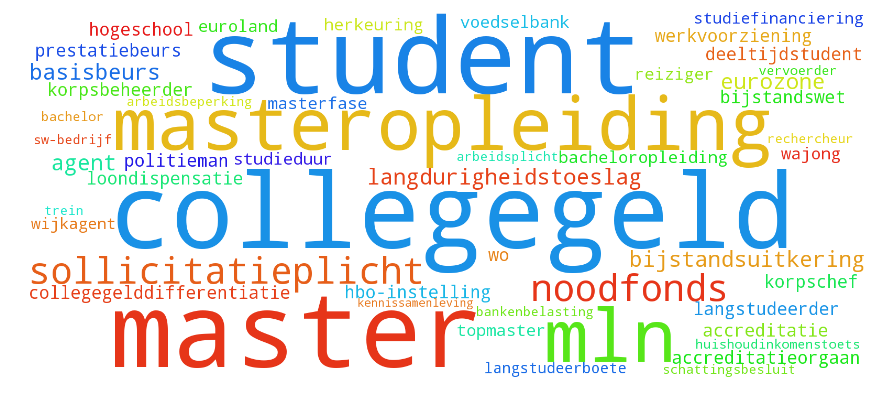

In [17]:
from wordcloud import WordCloud

top = pd.Series(data['jsd'])
top.sort(ascending=False)
print pd.DataFrame(top[:50]).to_latex(index=True, index_names=False, header=False)

words = [(wo, we) for wo, we in top[:50].iteritems()]
print words

wc = WordCloud(relative_scaling=0.7, prefer_horizontal=1.0, background_color="white", 
               height=700, width=1600,
               min_font_size=10, max_font_size=200).fit_words(words)
# font_path=font
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

## Topic Weights per Cabinet

Gewicht van topics in documenten per periode (kabinet)

9581.0
0.704757821337
cabinet
Balkenende I       1973
Balkenende II     10889
Balkenende III     1502
Balkenende IV     12031
Kok II             6767
Rutte I            9581
Name: total, dtype: float64


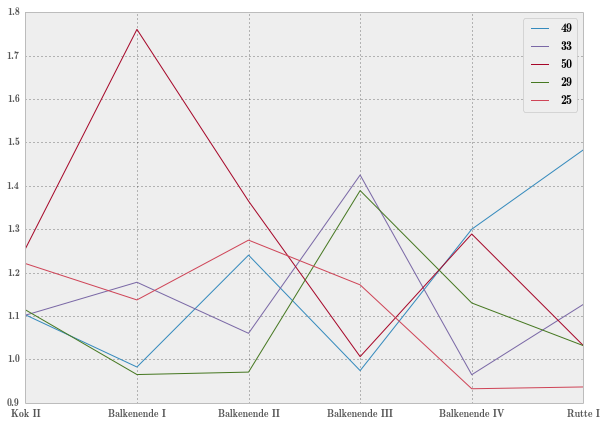

In [23]:
cabinets = ['Kok II-', 'Balkenende I-', 'Balkenende II-', 'Balkenende III-', 'Balkenende IV-', 'Rutte I-']
cabinets_order = ['Kok II', 'Balkenende I', 'Balkenende II', 'Balkenende III', 'Balkenende IV', 'Rutte I']

def get_cabinet(row):
    for c in cabinets:
        if row.name.startswith(c):
            return c.replace('-', '')
    return 'unknown'

theta['cabinet'] = theta.apply(get_cabinet, axis=1)

#theta['cabinet']

topic_sums = theta.groupby('cabinet').aggregate(sum)
topic_sums.loc[:, 'total'] = topic_sums.sum(axis=1)
for t in range(100):
    topic_sums[str(t)] = topic_sums.apply(lambda row: row[str(t)]/row['total']*100, axis=1)

print max(topic_sums.loc['Rutte I'])
print min(topic_sums.loc['Rutte I'])
print topic_sums['total']
topic_sums = topic_sums.reindex(cabinets_order)

#[str(t) for t in range(100)]
topic_sums[['49', '33', '50', '29', '25']].plot(kind='line')

In [25]:
from cptm.utils.topics import get_top_topic_words, topic_str

df = get_top_topic_words(phi_topic_t, phis_opinion_t, 49)
print topic_str(df, single_line=True, weights=True, opinions=False)

topic:	 leerling*0.0826 leraar*0.0461 docent*0.0326 kwaliteit*0.0204 klas*0.0187 mbo*0.0142 ouder*0.0135 vak*0.0120 stage*0.0111 les*0.0103


In [30]:
jsd = pd.read_csv('/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties/jsd_100.csv', index_col=0)
jsd2 = jsd.sort(['jsd'], ascending=False)
#print jsd2[:10].index
for idx in jsd2[:10].index:
    df = get_top_topic_words(phi_topic_t, phis_opinion_t, idx)
    print idx, topic_str(df, single_line=True, weights=False, opinions=False)


49 topic:	leerling leraar docent kwaliteit klas mbo ouder vak stage les
33 topic:	asielzoeker vreemdeling opvang terugkeer procedure verblijfsvergunning pardon herkomst verblijf illegaal
50 topic:	verdrag unie lidstaat parlement uitbreiding samenwerking onderhandeling toetreding top conventie
29 topic:	belasting belastingplan tarief heffing verlaging vennootschapsbelasting vrijstelling belastingdienst winst vermogen
25 topic:	werkgever werknemer arbeid partner cao sector arbeidsvoorwaarde dienst contract loon
86 topic:	premier koningin formatie informateur huis koning staatshoofd kandidaat parlement verkiezing
38 topic:	begroting uitgaaf groei tekort dekking lastenverlichting economie staatsschuld bedrag beschouwing
4 topic:	auto weg verkeer kilometerheffing waterstaat file mobiliteit km infrastructuur luchtkwaliteit
26 topic:	dier verbod dierenwelzijn sector vlees slacht welzijn kip volksgezondheid dierproef
52 topic:	samenleving waard politiek thema leven staat opvatting eeuw politic

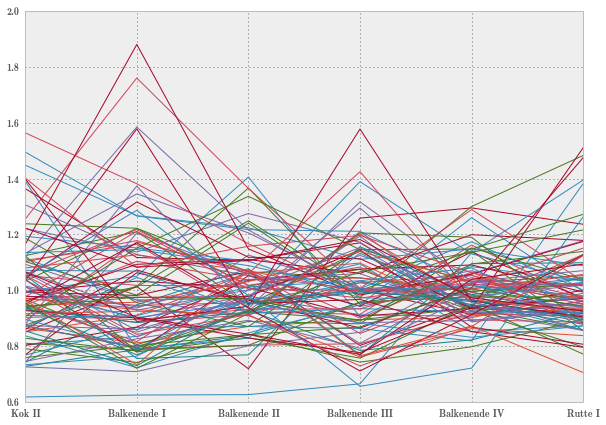

In [32]:
topic_sums[[str(t) for t in range(100)]].plot(kind='line', legend=None)

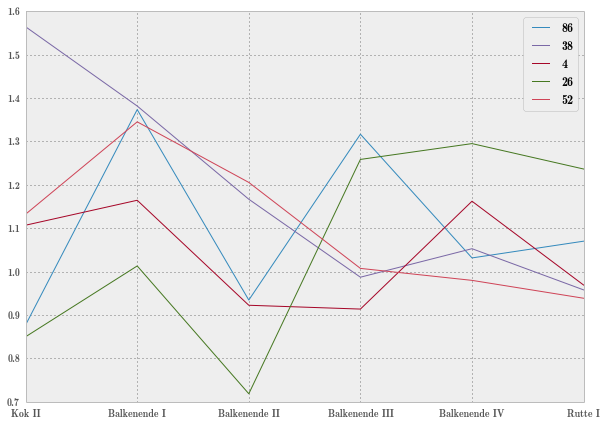

In [33]:
topic_sums[['86', '38', '4', '26', '52']].plot(kind='line')

In [20]:
#jsdFile = os.path.join(results_dir, 'jsd_{}.csv'.format(nTopics))
#jsd = pd.read_csv(jsdFile, index_col=0)
#print_topics(phi_topic_t, phis_opinion_t, nTopics, order=jsd)